In [2]:
import os
import sys
import rrdtool
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from auserverdata.preparation.rrd import *
from auserverdata.local import get_local_config
from auserverdata.analysis import plot_time_series_data
from joblib import Parallel,delayed
import pyarrow.parquet as pq
import pyarrow.compute as pc
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [3]:
local_config = get_local_config()

In [4]:
collectd_features_with_matching_timestamps = get_collectd_features_with_matching_timestamps(
                                                rrd_dir=local_config.rrd_dir,
                                                collectd_server='gpu1'
                                                )

In [5]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu1'])

### Data Preparation

The CPU Usage features for GPU1 have timestamps 2 seconds after the CPU Temperature. The below sets all features to have the timestamps of the CPU Usage features. There are 1200 datapoints in the data, each separated by 10 seconds. 

In [6]:
cpu_list = list({x for x in list(collectd_ts_df['gpu1'].columns.get_level_values(0)) if 'cpu' in x})
df1 = collectd_ts_df['gpu1'][cpu_list].dropna()
df1.columns = ['/'.join(col) for col in df1.columns]
df2 = collectd_ts_df['gpu1']['ipmi']['temperature-CPU1 Temp processor (3.1)'].dropna()
df1['temperature-CPU1 Temp processor (3.1)'] = df2.values

In [16]:
n_training_points = 1100
x = df1.iloc[:, :-1].values
y = df2.iloc[:, -1].values
x_train = df1.iloc[:n_training_points,:-1].values
y_train = df1.iloc[:n_training_points,-1].values
x_test = df1.iloc[n_training_points + 1:,:-1].values
y_test = df1.iloc[n_training_points + 1:,-1].values

model = xgb.XGBRegressor()
cv = KFold(n_splits=10)
# evaluate model
scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1)
# force scores to be positive
scores = np.abs(scores)
mean_score = np.mean(scores)

In [17]:
mean_score

0.5055827556956898

In [18]:
model.fit(x_train,y_train);
y_test_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_test_pred))

0.6724946147263652


In [10]:
feature_weights = model.get_booster().get_score(importance_type='weight')

In [11]:
x_train.shape

(1100, 192)

In [12]:
important_feature_indices = [x.replace('f','') for x in list(feature_weights.keys())]

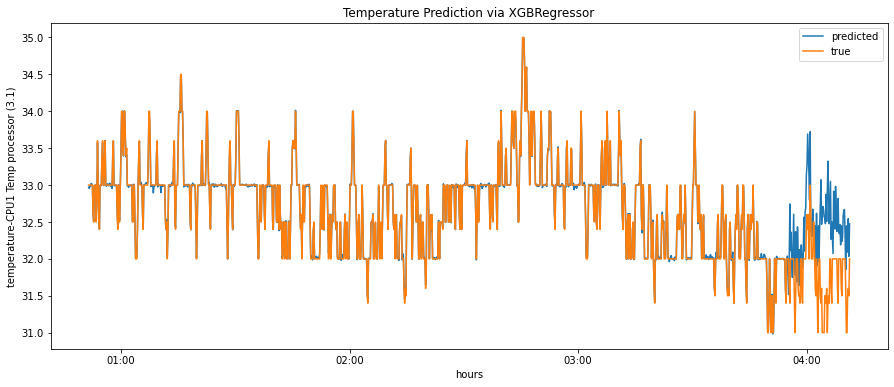

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
timestamps = [pd.to_datetime(x) for x in list(df1.iloc[:, :-1].index)]
plt.plot(timestamps, model.predict(x), label = 'predicted')
plt.plot(timestamps, y, label = 'true')
plt.title('Temperature Prediction via XGBRegressor')
plt.ylabel('temperature-CPU1 Temp processor (3.1)')
plt.xlabel('hours')
# Set the x-axis locator to show hours
ax.xaxis.set_major_locator(HourLocator(interval=1))  # This sets the tick interval to 1 hour

# Format the x-axis tick labels as hour:minute
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.legend()